In [62]:
# === Entry–Exit pairs: prep, means (TM points), and shares of TM (ratio-of-sums) ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ---------- paths ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

BASE     = find_upwards(Path("ValueCreation"))
WORK_CSV = (BASE / "Data" / "working.csv")

# ---------- load ----------
work = pd.read_csv(WORK_CSV, dtype={"deal_id": str})

# ---------- keep only the selected entry/exit types ----------
entry_keep = ["Primary Buyout","Secondary Buyout","Carve Out","Public to Private"]
exit_keep  = ["Sponsor-to-Sponsor","Corporate/Strategic","IPO","GP Lead Continuation"]

mask = work["entry_transaction_type"].isin(entry_keep) & work["exit_transaction_type"].isin(exit_keep)
work = work.loc[mask].copy()

# ---------- deal-view (1 row per deal) ----------
NUMERIC_COLS = [
    "times_money","leverage_effect","tm_unlevered",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
req = ["deal_id", "entry_transaction_type", "exit_transaction_type", *NUMERIC_COLS]
missing = [c for c in req if c not in work.columns]
assert not missing, f"Missing columns in working.csv: {missing}"

subset = work[req].copy()
subset = subset[
    subset["entry_transaction_type"].isin(entry_keep) &
    subset["exit_transaction_type"].isin(exit_keep)
]

deal = (subset.groupby("deal_id", as_index=False)
              .first()
              .rename(columns={
                  "entry_transaction_type": "entry_type",
                  "exit_transaction_type":  "exit_type"
              }))

# keep only the columns we actually need downstream
deal = deal[["deal_id","entry_type","exit_type", *NUMERIC_COLS]]

# ---- keep only selected entry/exit transaction types ----
entry_keep = ["Primary Buyout", "Secondary Buyout", "Carve Out", "Public to Private"]
exit_keep  = ["Sponsor-to-Sponsor", "Corporate/Strategic", "IPO", "GP Lead Continuation"]

deal_f = deal.loc[
    deal["entry_type"].isin(entry_keep) & deal["exit_type"].isin(exit_keep)
].copy()

# ---- pair counts ----
pair_counts = (
    deal_f.groupby(["entry_type", "exit_type"])["deal_id"]
          .nunique()
          .rename("n")
          .reset_index()
)

# Make a complete 4x4 matrix (include zeros for missing combos)
idx = pd.MultiIndex.from_product([entry_keep, exit_keep], names=["entry_type","exit_type"])
pair_counts_full = (
    pair_counts.set_index(["entry_type","exit_type"])
               .reindex(idx, fill_value=0)
               .rename_axis(index=["entry_type","exit_type"])
               .reset_index()
)

# Pretty print as a matrix (two equivalent options):

# Option A: pivot + fillna
print("Entry × Exit pair counts:")
print(
    pair_counts_full.pivot(index="entry_type", columns="exit_type", values="n")
                    .fillna(0).astype(int)
)

# Option B: pivot_table with fill_value
# print(
#     pair_counts.pivot_table(index="entry_type", columns="exit_type",
#                             values="n", aggfunc="sum", fill_value=0)
# )


# ---------- TM-point means per pair (Panel A-style) ----------
# ---------- TM-point means per pair (Panel A-style) ----------
grp = deal_f.groupby(["entry_type","exit_type"])  # <— use deal_f
means_tm_points = pd.DataFrame({
    "Times Money (levered)"  : grp["times_money"].mean(),
    "Leverage effect"        : grp["leverage_effect"].mean(),
    "Times Money (unlevered)": grp["tm_unlevered"].mean(),
    "Multiple effect"        : grp["tmu_contrib_multiple_effect"].mean(),
    "Combination (M×E)"      : grp["tmu_contrib_multiple_ebitda_combination_effect"].mean(),
    "Operating improvements" : grp["tmu_contrib_fcf_effect"].mean() + grp["tmu_contrib_ebitda_effect"].mean(),
    "FCF effect"             : grp["tmu_contrib_fcf_effect"].mean(),
    "EBITDA effect"          : grp["tmu_contrib_ebitda_effect"].mean(),
    "Sales effect"           : grp["tmu_contrib_sales_effect"].mean(),
    "Margin effect"          : grp["tmu_contrib_margin_effect"].mean(),
    "Combination (S×M)"      : grp["tmu_contrib_sales_margin_combination_effect"].mean(),
}).reset_index()

# ---------- Shares of TM per pair (ratio-of-sums) ----------
cols_needed = [
    "times_money","leverage_effect",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
S = deal_f.groupby(["entry_type","exit_type"])[cols_needed].sum().reset_index()  # <— use deal_f
S["den"] = S["times_money"].astype(float)

# If any pair has den≈0, drop it with a warning (prevents assertion explosions)
tiny = S["den"].abs() < 1e-12
if tiny.any():
    bad_pairs = S.loc[tiny, ["entry_type","exit_type"]].to_records(index=False).tolist()
    print("Warning: dropping pairs with ~zero total Times Money:", bad_pairs)
    S = S.loc[~tiny].copy()

def pct(col): return (S[col] / S["den"]) * 100.0

panelB_pairs = pd.DataFrame({
    "entry_type": S["entry_type"],
    "exit_type":  S["exit_type"],
    "Times Money (levered)"  : 100.0,
    "Leverage effect"        : pct("leverage_effect"),
    "Multiple effect"        : pct("tmu_contrib_multiple_effect"),
    "Combination (M×E)"      : pct("tmu_contrib_multiple_ebitda_combination_effect"),
    "FCF effect"             : pct("tmu_contrib_fcf_effect"),
    "EBITDA effect"          : pct("tmu_contrib_ebitda_effect"),
    "Sales effect"           : pct("tmu_contrib_sales_effect"),
    "Margin effect"          : pct("tmu_contrib_margin_effect"),
    "Combination (S×M)"      : pct("tmu_contrib_sales_margin_combination_effect"),
})
panelB_pairs["Operating improvements"]  = panelB_pairs["FCF effect"] + panelB_pairs["EBITDA effect"]
panelB_pairs["Times Money (unlevered)"] = (
    panelB_pairs["Multiple effect"] + panelB_pairs["Combination (M×E)"] + panelB_pairs["Operating improvements"]
)

# Long forms for plotting
means_long  = means_tm_points.melt(id_vars=["entry_type","exit_type"], var_name="component", value_name="tm_points")
shares_long = panelB_pairs.melt(id_vars=["entry_type","exit_type"], var_name="component", value_name="share_pct")


# For convenience: long versions for plotting
means_long = means_tm_points.melt(id_vars=["entry_type","exit_type"], var_name="component", value_name="tm_points")
shares_long = panelB_pairs.melt(id_vars=["entry_type","exit_type"], var_name="component", value_name="share_pct")

# Pretty print as a matrix (complete 4x4 with zeros)
print("Entry × Exit pair counts:")
print(
    pair_counts_full.pivot(index="entry_type", columns="exit_type", values="n")
                    .fillna(0).astype(int)
)


Entry × Exit pair counts:
exit_type          Corporate/Strategic  GP Lead Continuation  IPO  \
entry_type                                                          
Carve Out                            2                     0    0   
Primary Buyout                      19                     0    0   
Public to Private                    2                     1    0   
Secondary Buyout                    14                     1    4   

exit_type          Sponsor-to-Sponsor  
entry_type                             
Carve Out                           0  
Primary Buyout                     18  
Public to Private                   3  
Secondary Buyout                   26  
Entry × Exit pair counts:
exit_type          Corporate/Strategic  GP Lead Continuation  IPO  \
entry_type                                                          
Carve Out                            2                     0    0   
Primary Buyout                      19                     0    0   
Public to Private

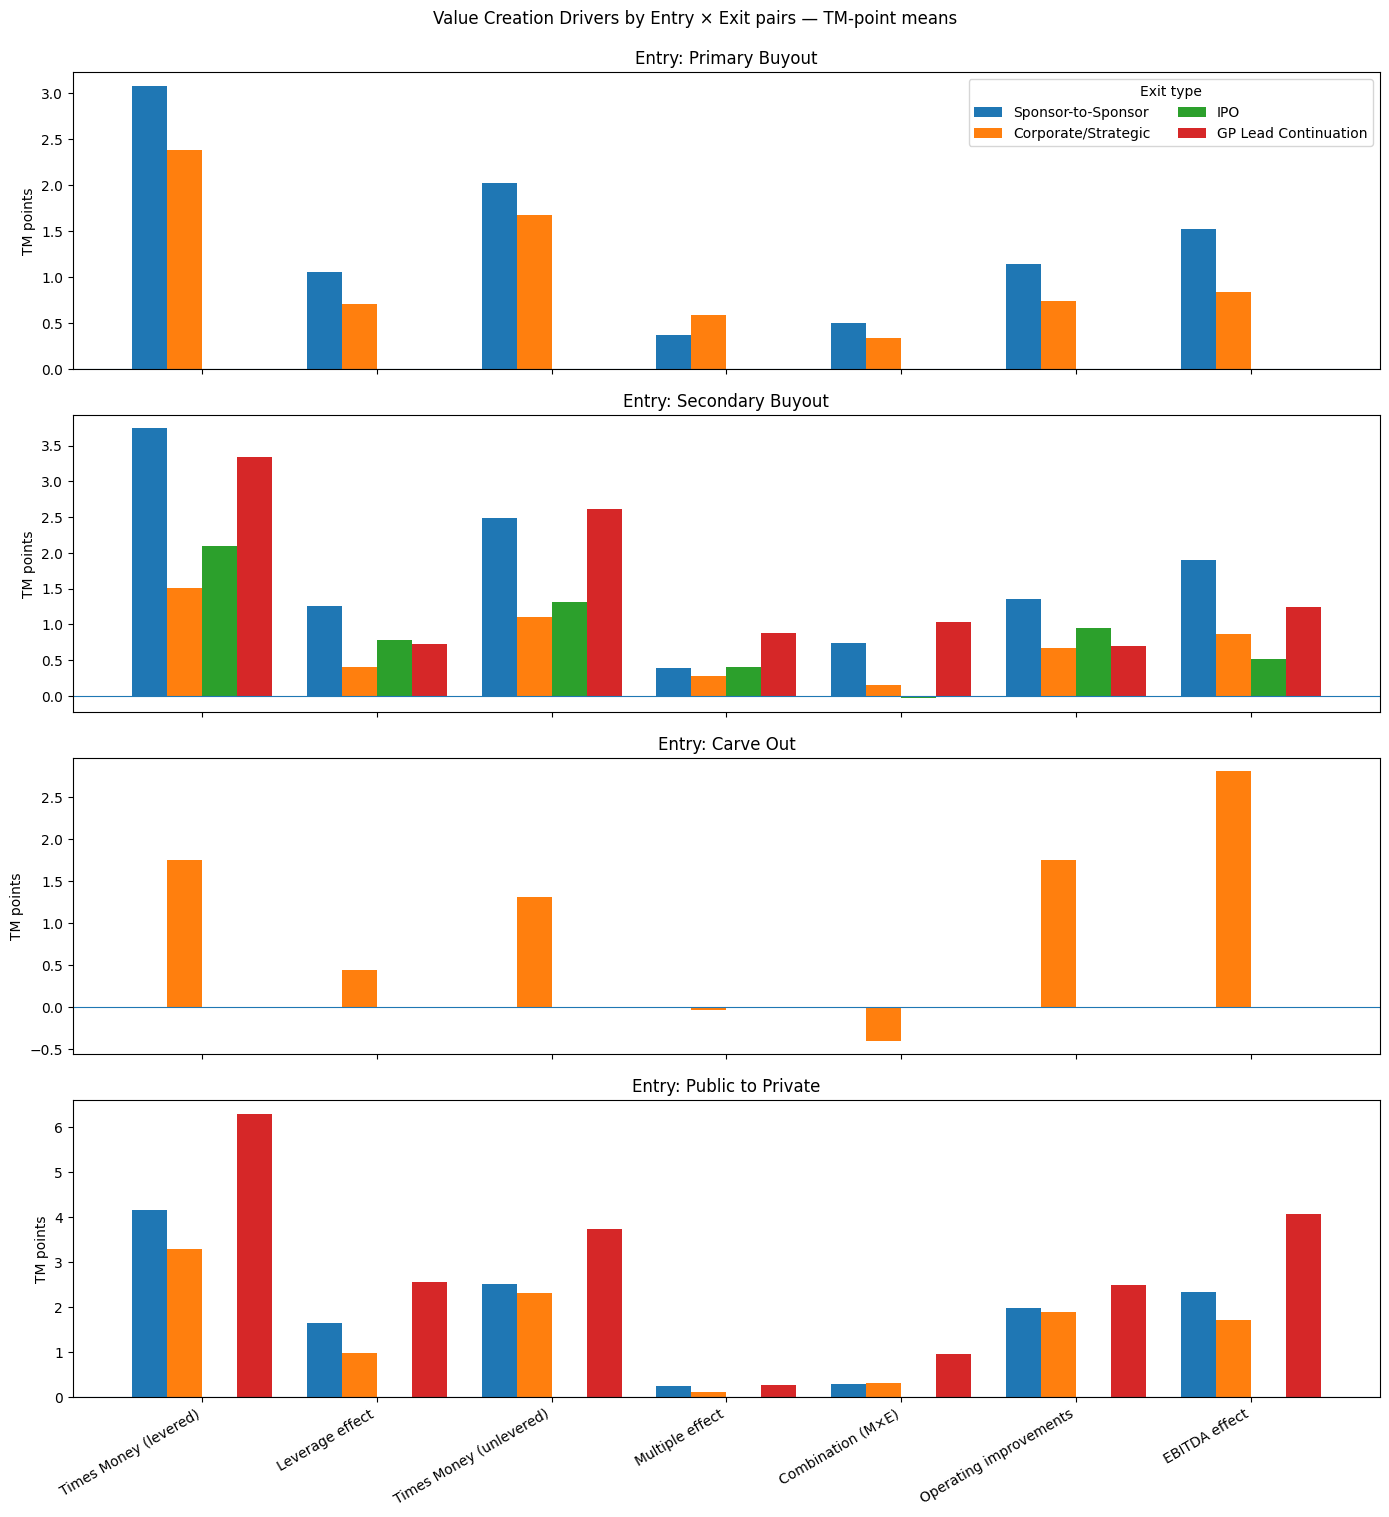

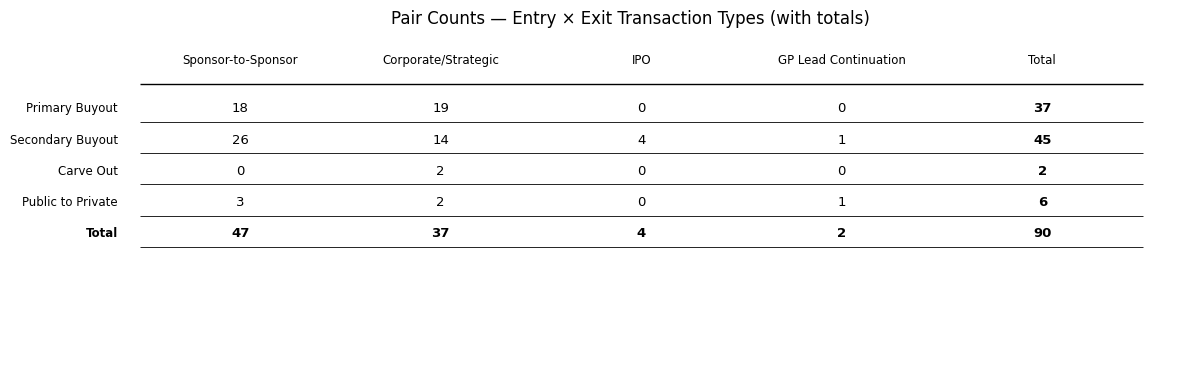

In [63]:
# === Option B: Small-multiple clustered bars (rows=entry types; bars=exit types) ===

ENTRY = entry_keep
EXIT  = exit_keep

components_to_show = [
    "Times Money (levered)","Leverage effect","Times Money (unlevered)",
    "Multiple effect","Combination (M×E)","Operating improvements",
    "EBITDA effect"
]
subset = means_long[means_long["component"].isin(components_to_show)].copy()

n_rows = len(ENTRY)
fig, axes = plt.subplots(n_rows, 1, figsize=(14, 3.8*n_rows), sharex=True)

if n_rows == 1:
    axes = [axes]

for ax, e in zip(axes, ENTRY):
    sub = subset[subset["entry_type"] == e].copy()
    # Ensure consistent component ordering
    sub["component"] = pd.Categorical(sub["component"], categories=components_to_show, ordered=True)
    sub = sub.sort_values(["component","exit_type"])

    x = np.arange(len(components_to_show))
    width = 0.8 / len(EXIT)

    # Draw clusters: one bar per exit type at each component position
    for i, ex in enumerate(EXIT):
        vals = (sub[sub["exit_type"] == ex]
                .set_index("component")
                .reindex(components_to_show)["tm_points"].to_numpy())
        ax.bar(x + (i - (len(EXIT)-1)/2)*width, vals, width=width, label=ex)

    ax.axhline(0, linewidth=0.8)
    ax.set_ylabel("TM points")
    ax.set_title(f"Entry: {e}")
    ax.set_xticks(x)
    ax.set_xticklabels(components_to_show, rotation=30, ha="right")

axes[0].legend(title="Exit type", ncol=2)
fig.suptitle("Value Creation Drivers by Entry × Exit pairs — TM-point means", y=0.995)
fig.tight_layout()
plt.show()


# === Descriptive statistics for the panel ===
# === Panel — Entry × Exit pair counts (compact row height) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# 1) Count matrix (complete 4x4, zeros where pair doesn't exist)
pair_counts = (
    deal_f.groupby(["entry_type","exit_type"])["deal_id"]
          .nunique()
          .rename("n")
          .reset_index()
)
idx = pd.MultiIndex.from_product([entry_keep, exit_keep], names=["entry_type","exit_type"])
pair_counts_full = (pair_counts.set_index(["entry_type","exit_type"])
                               .reindex(idx, fill_value=0)
                               .rename_axis(index=["entry_type","exit_type"])
                               .reset_index())
count_matrix = (pair_counts_full
                .pivot(index="entry_type", columns="exit_type", values="n")
                .reindex(index=entry_keep, columns=exit_keep)
                .astype(int))

# assumes: count_matrix (or build from pair_counts_full as before)
ADD_TOTALS = True
if ADD_TOTALS:
    count_with_totals = count_matrix.copy()
    count_with_totals["Total"] = count_with_totals.sum(axis=1)
    totals_row = pd.DataFrame([count_with_totals.sum(axis=0)], index=["Total"])
    count_with_totals = pd.concat([count_with_totals, totals_row], axis=0)
else:
    count_with_totals = count_matrix

headers = list(count_with_totals.columns)
rows    = list(count_with_totals.index)

n_cols = len(headers)
n_rows = len(rows)

# ↓↓↓ compact height & spacing (≈50% tighter) ↓↓↓
fig_h  = 3.0 + max(0, n_rows-1) * 0.25     # was ~3.6 + (n_rows-1)*0.5
row_start = 0.78                            # was 0.72
row_gap   = 0.09                            # was 0.18
y_header  = 0.92                            # was 0.90
# ↑↑↑ compact height & spacing ↑↑↑

fig, ax = plt.subplots(figsize=(12, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols
ys = [row_start - i*row_gap for i in range(n_rows)]

wrap_w = 20
for x_pos, hdr in zip(xs, headers):
    ax.text(x_pos, y_header, textwrap.fill(str(hdr), width=wrap_w),
            ha="center", va="center", fontsize=8.5, linespacing=1.05, transform=ax.transAxes)

row_label_x = left_margin - 0.02
for y_pos, r in zip(ys, rows):
    ax.text(row_label_x, y_pos, str(r),
            ha="right", va="center", fontsize=8.5,
            fontweight="bold" if r=="Total" else None,
            transform=ax.transAxes)
    for x_pos, v in zip(xs, count_with_totals.loc[r, headers]):
        ax.text(x_pos, y_pos, f"{int(v)}",
                ha="center", va="center",
                fontsize=9.5, fontweight="bold" if (r=="Total" or x_pos==xs[-1]) else None,
                transform=ax.transAxes)

sep_top = (y_header + ys[0]) / 2
ax.hlines([sep_top], xmin=left_margin, xmax=right_margin,
          colors="black", linewidth=1.0, transform=ax.transAxes)
for y_pos in ys:
    ax.hlines([y_pos - row_gap/2 + 0.008], xmin=left_margin, xmax=right_margin,
              colors="black", linewidth=0.6, transform=ax.transAxes)

title = "Pair Counts — Entry × Exit Transaction Types" + (" (with totals)" if ADD_TOTALS else "")
ax.set_title(title, pad=6)
fig.tight_layout()
plt.show()


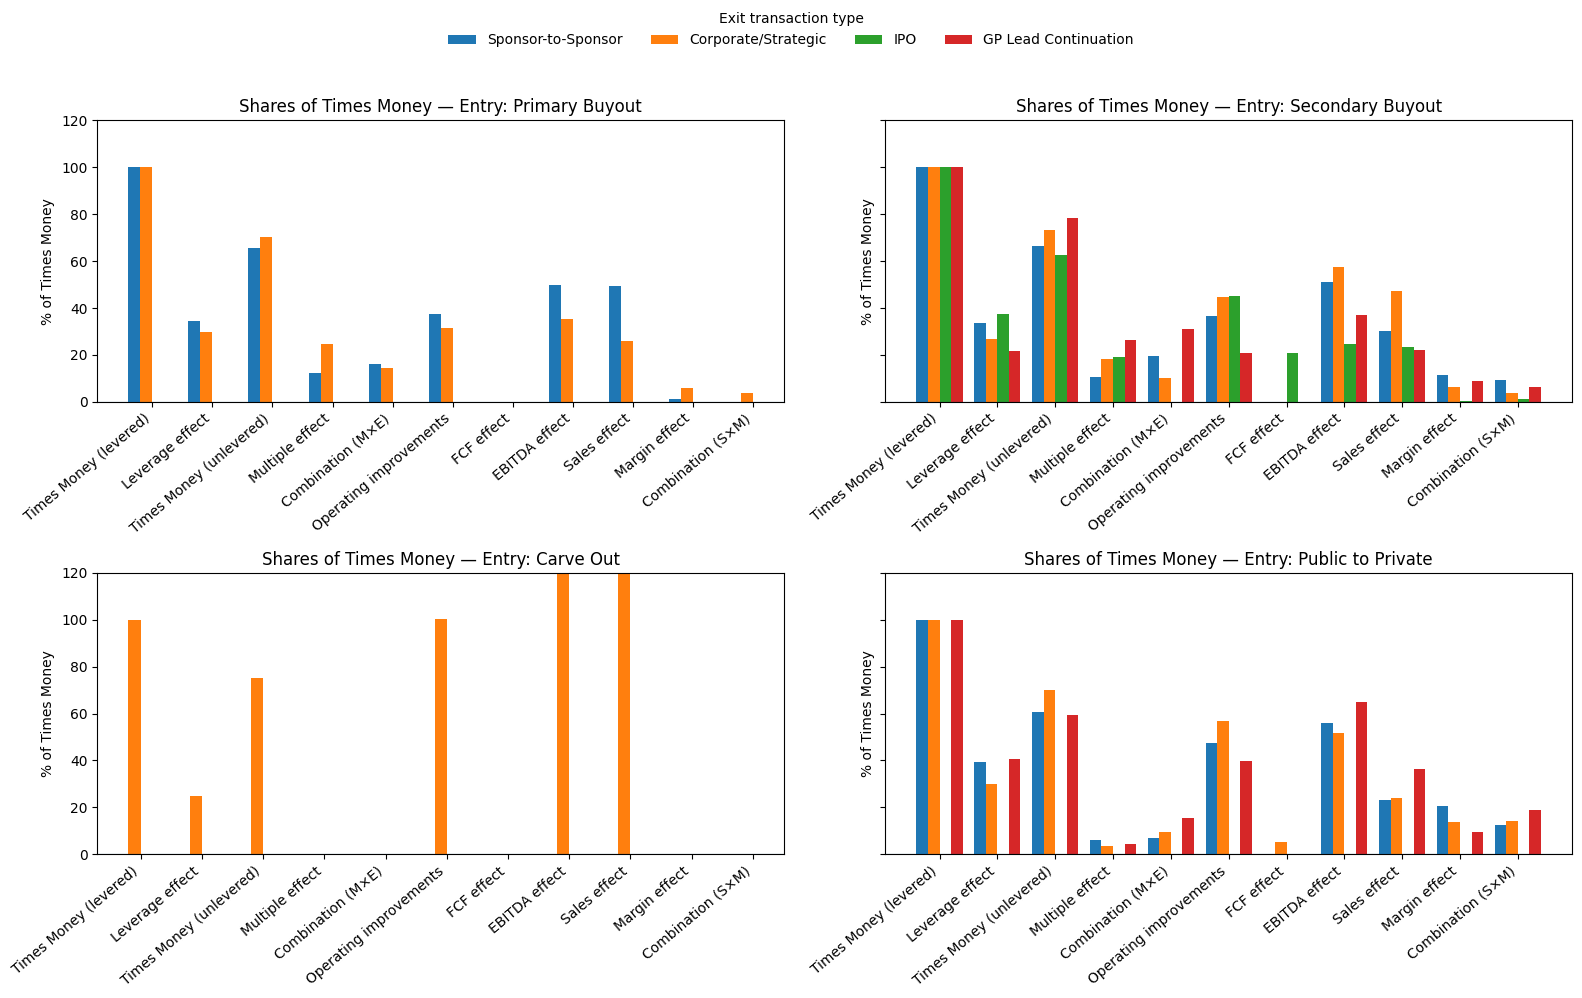

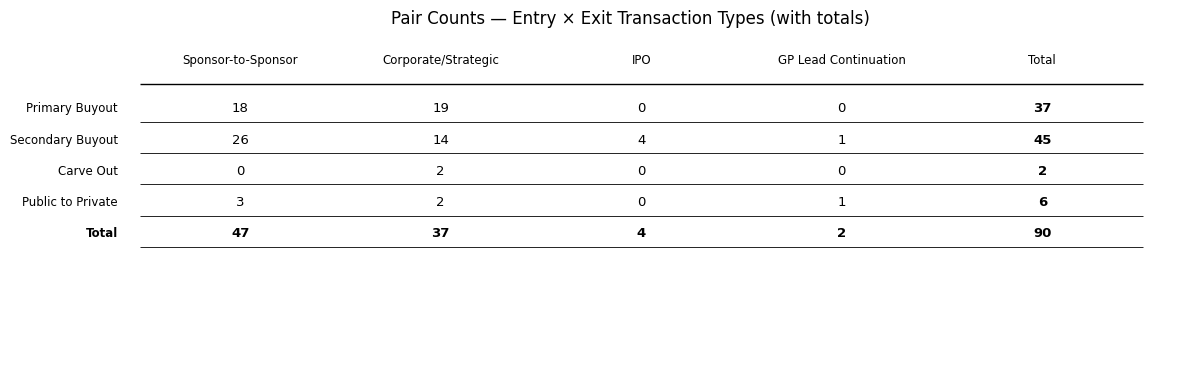

In [64]:
# === Charts: shares of Times Money (%), one clustered-bar chart per ENTRY TYPE ===
import numpy as np
import matplotlib.pyplot as plt

# Component order (match your Panel B)
components = [
    "Times Money (levered)",
    "Leverage effect",
    "Times Money (unlevered)",
    "Multiple effect",
    "Combination (M×E)",
    "Operating improvements",
    "FCF effect",
    "EBITDA effect",
    "Sales effect",
    "Margin effect",
    "Combination (S×M)",
]

# Make a stable copy (only pairs we computed shares for)
P = panelB_pairs.copy()

# 2x2 small multiples for the 4 entry types
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
axes = axes.flatten()

for ax, entry in zip(axes, entry_keep):
    # slice, pivot to: rows = components, cols = exit types (ordered)
    sub = (P.loc[P["entry_type"] == entry, ["exit_type", *components]]
             .set_index("exit_type")
             .reindex(exit_keep)  # keep consistent exit-type order
             .T)                  # rows=components, cols=exit types

    x = np.arange(len(components))
    n_exit = len(exit_keep)
    width = 0.8 / n_exit

    # Grouped bars across exit types
    for i, ex in enumerate(exit_keep):
        vals = sub.get(ex, np.nan)  # may be all-NaN if pair never occurs
        ax.bar(x + (i - (n_exit-1)/2) * width, vals.to_numpy(),
               width=width, label=ex)

    ax.set_title(f"Shares of Times Money — Entry: {entry}")
    ax.set_xticks(x)
    ax.set_xticklabels(components, rotation=40, ha="right")
    ax.axhline(0, linewidth=0.8)
    ax.set_ylim(0, 120)  # 100% baseline + a little headroom
    ax.set_ylabel("% of Times Money")

# One legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Exit transaction type", loc="upper center", ncol=4, frameon=False)

fig.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


# === Descriptive statistics for the panel ===
# === Panel — Entry × Exit pair counts (compact row height) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# 1) Count matrix (complete 4x4, zeros where pair doesn't exist)
pair_counts = (
    deal_f.groupby(["entry_type","exit_type"])["deal_id"]
          .nunique()
          .rename("n")
          .reset_index()
)
idx = pd.MultiIndex.from_product([entry_keep, exit_keep], names=["entry_type","exit_type"])
pair_counts_full = (pair_counts.set_index(["entry_type","exit_type"])
                               .reindex(idx, fill_value=0)
                               .rename_axis(index=["entry_type","exit_type"])
                               .reset_index())
count_matrix = (pair_counts_full
                .pivot(index="entry_type", columns="exit_type", values="n")
                .reindex(index=entry_keep, columns=exit_keep)
                .astype(int))

# assumes: count_matrix (or build from pair_counts_full as before)
ADD_TOTALS = True
if ADD_TOTALS:
    count_with_totals = count_matrix.copy()
    count_with_totals["Total"] = count_with_totals.sum(axis=1)
    totals_row = pd.DataFrame([count_with_totals.sum(axis=0)], index=["Total"])
    count_with_totals = pd.concat([count_with_totals, totals_row], axis=0)
else:
    count_with_totals = count_matrix

headers = list(count_with_totals.columns)
rows    = list(count_with_totals.index)

n_cols = len(headers)
n_rows = len(rows)

# ↓↓↓ compact height & spacing (≈50% tighter) ↓↓↓
fig_h  = 3.0 + max(0, n_rows-1) * 0.25     # was ~3.6 + (n_rows-1)*0.5
row_start = 0.78                            # was 0.72
row_gap   = 0.09                            # was 0.18
y_header  = 0.92                            # was 0.90
# ↑↑↑ compact height & spacing ↑↑↑

fig, ax = plt.subplots(figsize=(12, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols
ys = [row_start - i*row_gap for i in range(n_rows)]

wrap_w = 20
for x_pos, hdr in zip(xs, headers):
    ax.text(x_pos, y_header, textwrap.fill(str(hdr), width=wrap_w),
            ha="center", va="center", fontsize=8.5, linespacing=1.05, transform=ax.transAxes)

row_label_x = left_margin - 0.02
for y_pos, r in zip(ys, rows):
    ax.text(row_label_x, y_pos, str(r),
            ha="right", va="center", fontsize=8.5,
            fontweight="bold" if r=="Total" else None,
            transform=ax.transAxes)
    for x_pos, v in zip(xs, count_with_totals.loc[r, headers]):
        ax.text(x_pos, y_pos, f"{int(v)}",
                ha="center", va="center",
                fontsize=9.5, fontweight="bold" if (r=="Total" or x_pos==xs[-1]) else None,
                transform=ax.transAxes)

sep_top = (y_header + ys[0]) / 2
ax.hlines([sep_top], xmin=left_margin, xmax=right_margin,
          colors="black", linewidth=1.0, transform=ax.transAxes)
for y_pos in ys:
    ax.hlines([y_pos - row_gap/2 + 0.008], xmin=left_margin, xmax=right_margin,
              colors="black", linewidth=0.6, transform=ax.transAxes)

title = "Pair Counts — Entry × Exit Transaction Types" + (" (with totals)" if ADD_TOTALS else "")
ax.set_title(title, pad=6)
fig.tight_layout()
plt.show()


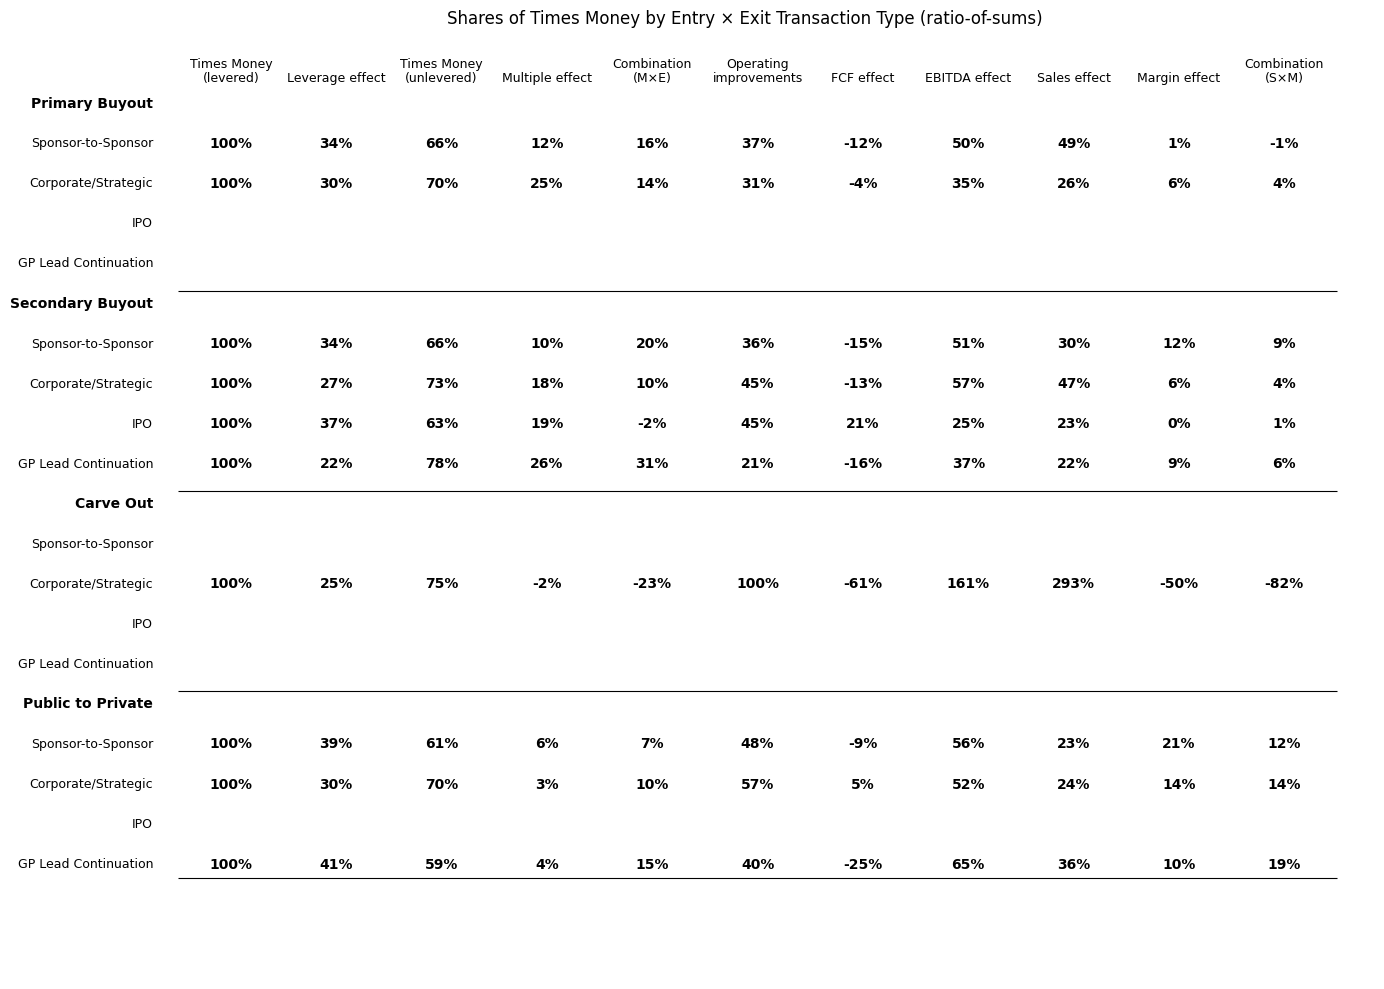

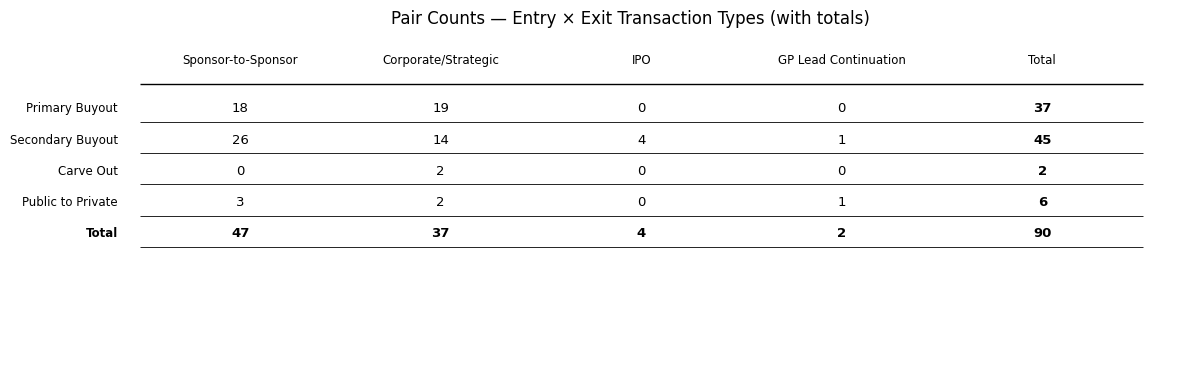

In [65]:
# === Table-style (Panel B-like) — four sections stacked, values in % of Times Money ===
import matplotlib.pyplot as plt
import textwrap
import numpy as np
import pandas as pd

components = [
    "Times Money (levered)",
    "Leverage effect",
    "Times Money (unlevered)",
    "Multiple effect",
    "Combination (M×E)",
    "Operating improvements",
    "FCF effect",
    "EBITDA effect",
    "Sales effect",
    "Margin effect",
    "Combination (S×M)",
]

# Build a big table: rows = (Entry section header + each Exit type), cols = components
sections = []
row_labels = []   # left gutter labels
section_titles = []  # one per section

for entry in entry_keep:
    # header row for the section (label only)
    section_titles.append(entry)
    row_labels.append(entry)  # we’ll render this as a bold section label

    # slice data for this entry; ensure exit order
    sub = (panelB_pairs.loc[panelB_pairs["entry_type"] == entry,
                            ["exit_type", *components]]
                        .set_index("exit_type")
                        .reindex(exit_keep))
    sections.append(sub)

    # then the exit rows labels
    row_labels.extend(exit_keep)

# Concatenate with a blank header row per section
# We'll build a 2-level structure for drawing; easier to track y-positions.
rows = []
which_section = []
for entry, sub in zip(entry_keep, sections):
    # section header marker (None row)
    rows.append(pd.Series({c: np.nan for c in components}, name=("__section__", entry)))
    which_section.append(entry)
    # exit rows
    for ex in exit_keep:
        s = sub.loc[ex] if ex in sub.index else pd.Series({c: np.nan for c in components})
        s.name = (ex, entry)  # (exit, entry)
        rows.append(s)
        which_section.append(entry)

table = pd.DataFrame(rows)

# Layout
n_cols = len(components)
n_rows = len(table)
fig_h = 3.0 + 0.35 * n_rows  # dynamic height
fig, ax = plt.subplots(figsize=(14, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols

# Y positions top-down
top_y = 0.93
row_gap = (top_y - 0.08) / max(n_rows, 1)
ys = [top_y - i * row_gap for i in range(n_rows)]

# Headers
wrap_w = 16
y_header = ys[0] + 0.02
for x, hdr in zip(xs, components):
    ax.text(x, y_header, textwrap.fill(hdr, width=wrap_w),
            ha="center", va="bottom", fontsize=9, linespacing=1.05, transform=ax.transAxes)

# Draw rows
row_label_x = left_margin - 0.02
curr_section = None
for i, (idx, row) in enumerate(table.iterrows()):
    y = ys[i]

    # Section header row?
    is_section = (isinstance(idx, tuple) and idx[0] == "__section__")
    if is_section:
        entry = idx[1]
        # Section title (bold)
        ax.text(row_label_x, y, f"{entry}",
                ha="right", va="center", fontsize=10, fontweight="bold", transform=ax.transAxes)
        # horizontal rule above section (except first)
        if curr_section is not None:
            ax.hlines([y + row_gap*0.30], xmin=left_margin, xmax=right_margin,
                      colors="black", linewidth=0.8, transform=ax.transAxes)
        curr_section = entry
        continue

    # Exit label
    exit_label = idx[0] if isinstance(idx, tuple) else str(idx)
    ax.text(row_label_x, y, exit_label,
            ha="right", va="center", fontsize=9, transform=ax.transAxes)

    # Values
    for x, hdr in zip(xs, components):
        val = row.get(hdr)
        if pd.notna(val):
            ax.text(x, y, f"{val:.0f}%", ha="center", va="center",
                    fontsize=10, fontweight="bold", transform=ax.transAxes)

# Bottom rule
ax.hlines([ys[-1] - row_gap*0.35], xmin=left_margin, xmax=right_margin,
          colors="black", linewidth=0.8, transform=ax.transAxes)

ax.set_title("Shares of Times Money by Entry × Exit Transaction Type (ratio-of-sums)", pad=10)
fig.tight_layout()
plt.show()


# === Panel — Entry × Exit pair counts (compact row height) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# 1) Count matrix (complete 4x4, zeros where pair doesn't exist)
pair_counts = (
    deal_f.groupby(["entry_type","exit_type"])["deal_id"]
          .nunique()
          .rename("n")
          .reset_index()
)
idx = pd.MultiIndex.from_product([entry_keep, exit_keep], names=["entry_type","exit_type"])
pair_counts_full = (pair_counts.set_index(["entry_type","exit_type"])
                               .reindex(idx, fill_value=0)
                               .rename_axis(index=["entry_type","exit_type"])
                               .reset_index())
count_matrix = (pair_counts_full
                .pivot(index="entry_type", columns="exit_type", values="n")
                .reindex(index=entry_keep, columns=exit_keep)
                .astype(int))

# assumes: count_matrix (or build from pair_counts_full as before)
ADD_TOTALS = True
if ADD_TOTALS:
    count_with_totals = count_matrix.copy()
    count_with_totals["Total"] = count_with_totals.sum(axis=1)
    totals_row = pd.DataFrame([count_with_totals.sum(axis=0)], index=["Total"])
    count_with_totals = pd.concat([count_with_totals, totals_row], axis=0)
else:
    count_with_totals = count_matrix

headers = list(count_with_totals.columns)
rows    = list(count_with_totals.index)

n_cols = len(headers)
n_rows = len(rows)

# ↓↓↓ compact height & spacing (≈50% tighter) ↓↓↓
fig_h  = 3.0 + max(0, n_rows-1) * 0.25     # was ~3.6 + (n_rows-1)*0.5
row_start = 0.78                            # was 0.72
row_gap   = 0.09                            # was 0.18
y_header  = 0.92                            # was 0.90
# ↑↑↑ compact height & spacing ↑↑↑

fig, ax = plt.subplots(figsize=(12, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols
ys = [row_start - i*row_gap for i in range(n_rows)]

wrap_w = 20
for x_pos, hdr in zip(xs, headers):
    ax.text(x_pos, y_header, textwrap.fill(str(hdr), width=wrap_w),
            ha="center", va="center", fontsize=8.5, linespacing=1.05, transform=ax.transAxes)

row_label_x = left_margin - 0.02
for y_pos, r in zip(ys, rows):
    ax.text(row_label_x, y_pos, str(r),
            ha="right", va="center", fontsize=8.5,
            fontweight="bold" if r=="Total" else None,
            transform=ax.transAxes)
    for x_pos, v in zip(xs, count_with_totals.loc[r, headers]):
        ax.text(x_pos, y_pos, f"{int(v)}",
                ha="center", va="center",
                fontsize=9.5, fontweight="bold" if (r=="Total" or x_pos==xs[-1]) else None,
                transform=ax.transAxes)

sep_top = (y_header + ys[0]) / 2
ax.hlines([sep_top], xmin=left_margin, xmax=right_margin,
          colors="black", linewidth=1.0, transform=ax.transAxes)
for y_pos in ys:
    ax.hlines([y_pos - row_gap/2 + 0.008], xmin=left_margin, xmax=right_margin,
              colors="black", linewidth=0.6, transform=ax.transAxes)

title = "Pair Counts — Entry × Exit Transaction Types" + (" (with totals)" if ADD_TOTALS else "")
ax.set_title(title, pad=6)
fig.tight_layout()
plt.show()


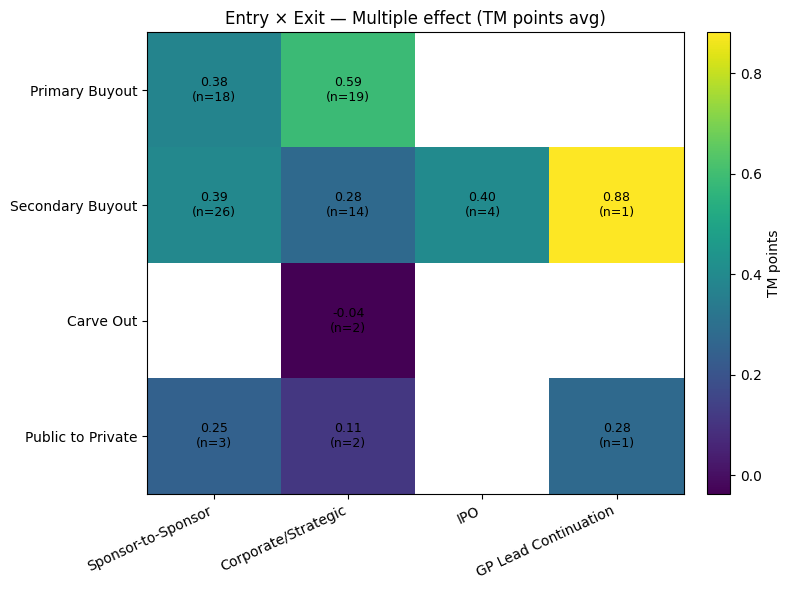

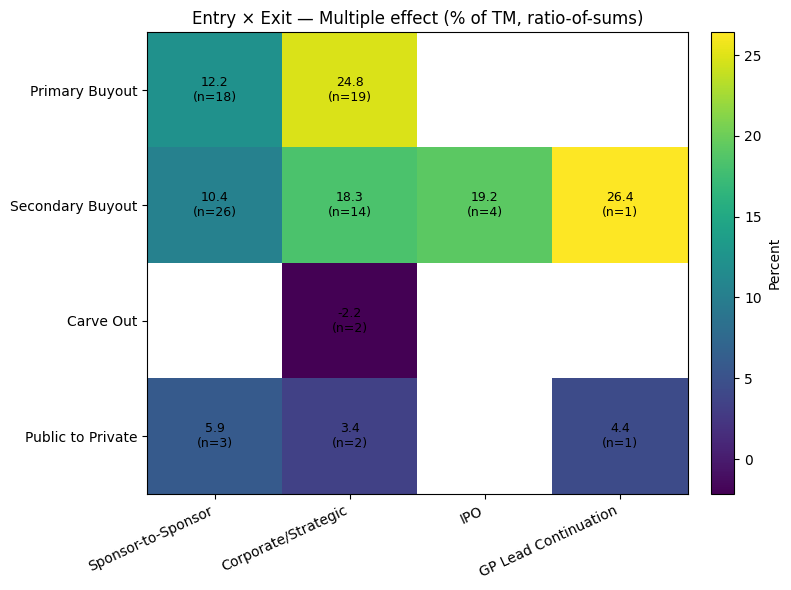

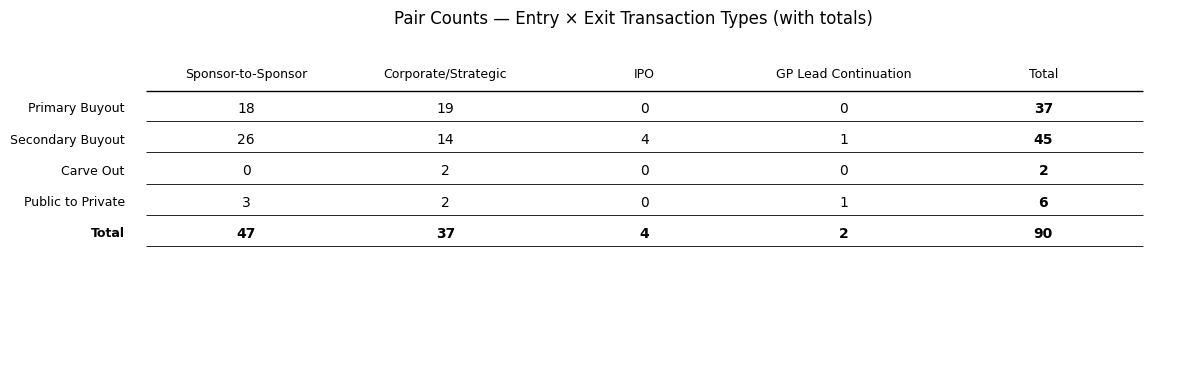

Skipping extra stats panel (missing columns in deal_f).


In [66]:
# === Option A: Heatmap-by-component (choose TM points or shares) ===
import numpy as np
import matplotlib.pyplot as plt

ENTRY = entry_keep
EXIT  = exit_keep

def heatmap_for(component: str, use_shares: bool = False, cmap="viridis"):
    src = shares_long if use_shares else means_long
    val_col = "share_pct" if use_shares else "tm_points"
    title_suffix = " (% of TM, ratio-of-sums)" if use_shares else " (TM points avg)"

    pivot = src[src["component"] == component].pivot(index="entry_type", columns="exit_type", values=val_col)
    pivot = pivot.reindex(index=ENTRY, columns=EXIT)

    # counts overlay
    N = pair_counts.pivot(index="entry_type", columns="exit_type", values="n").reindex(index=ENTRY, columns=EXIT)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(pivot.values, aspect="auto", cmap=cmap)
    ax.set_xticks(np.arange(len(EXIT)));  ax.set_xticklabels(EXIT, rotation=25, ha="right")
    ax.set_yticks(np.arange(len(ENTRY))); ax.set_yticklabels(ENTRY)

    # annotate with value and n
    for i in range(len(ENTRY)):
        for j in range(len(EXIT)):
            v = pivot.values[i, j]
            n = N.values[i, j]
            if pd.notna(v):
                label = f"{v:.1f}" if use_shares else f"{v:.2f}"
                ax.text(j, i, f"{label}\n(n={int(n)})", ha="center", va="center", fontsize=9)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Percent" if use_shares else "TM points")
    ax.set_title(f"Entry × Exit — {component}{title_suffix}")
    fig.tight_layout()
    plt.show()

# Example calls:
heatmap_for("Multiple effect", use_shares=False)  # TM points
heatmap_for("Multiple effect", use_shares=True)   # shares of TM



# === Descriptive statistics for the panel ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# 1) Count matrix (complete 4x4, zeros where pair doesn't exist)
pair_counts = (
    deal_f.groupby(["entry_type","exit_type"])["deal_id"]
          .nunique()
          .rename("n")
          .reset_index()
)
idx = pd.MultiIndex.from_product([entry_keep, exit_keep], names=["entry_type","exit_type"])
pair_counts_full = (pair_counts.set_index(["entry_type","exit_type"])
                               .reindex(idx, fill_value=0)
                               .rename_axis(index=["entry_type","exit_type"])
                               .reset_index())
count_matrix = (pair_counts_full
                .pivot(index="entry_type", columns="exit_type", values="n")
                .reindex(index=entry_keep, columns=exit_keep)
                .astype(int))

# 2) Optional totals (row/col + grand total)
ADD_TOTALS = True
if ADD_TOTALS:
    count_with_totals = count_matrix.copy()
    count_with_totals["Total"] = count_with_totals.sum(axis=1)
    totals_row = pd.DataFrame([count_with_totals.sum(axis=0)], index=["Total"])
    count_with_totals = pd.concat([count_with_totals, totals_row], axis=0)
else:
    count_with_totals = count_matrix

# 3) Draw Panel-style table
headers = list(count_with_totals.columns)
rows    = list(count_with_totals.index)

n_cols = len(headers)
n_rows = len(rows)

fig_h  = 3.0 + max(0, n_rows-1) * 0.25
fig, ax = plt.subplots(figsize=(12, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols

row_start = 0.78                            # was 0.72
row_gap   = 0.09                            # was 0.18
y_header  = 0.88                          # was 0.90
ys = [row_start - i*row_gap for i in range(n_rows)]

wrap_w = 20
# headers
for x_pos, hdr in zip(xs, headers):
    ax.text(x_pos, y_header, textwrap.fill(str(hdr), width=wrap_w),
            ha="center", va="center", fontsize=9, linespacing=1.05, transform=ax.transAxes)

# row labels + values
row_label_x = left_margin - 0.02
for y_pos, r in zip(ys, rows):
    # left labels
    ax.text(row_label_x, y_pos, str(r),
            ha="right", va="center", fontsize=9, fontweight="bold" if r=="Total" else None, transform=ax.transAxes)
    # cells
    vals = count_with_totals.loc[r, headers]
    for x_pos, v in zip(xs, vals):
        ax.text(x_pos, y_pos, f"{int(v)}",
                ha="center", va="center",
                fontsize=10, fontweight="bold" if (r=="Total" or x_pos==xs[-1]) else None,
                transform=ax.transAxes)

# rules
sep_top = (y_header + ys[0]) / 2
ax.hlines([sep_top], xmin=left_margin, xmax=right_margin, colors="black", linewidth=1.0, transform=ax.transAxes)
for y_pos in ys:
    ax.hlines([y_pos - row_gap/2 + 0.01], xmin=left_margin, xmax=right_margin,
              colors="black", linewidth=0.6, transform=ax.transAxes)

title = "Pair Counts — Entry × Exit Transaction Types"
if ADD_TOTALS: title += " (with totals)"
ax.set_title(title, pad=6)
fig.tight_layout()
plt.show()

# === Optional mini-panel — medians by pair (levered TM % and holding period, if available) ===
# Requires `times_money` and `holding_period` to exist in `deal_f` (deal-view).
INCLUDE_EXTRA_STATS = True
if INCLUDE_EXTRA_STATS:
    # Build one row per deal; ensure these exist
    need_cols = {"entry_type","exit_type","times_money","holding_period"}
    if not need_cols.issubset(deal_f.columns):
        print("Skipping extra stats panel (missing columns in deal_f).")
    else:
        G = (deal_f.groupby(["entry_type","exit_type"])
                    .agg(n=("deal_id","nunique"),
                         med_TM=("times_money","median"),
                         med_HP=("holding_period","median"))
                    .reset_index())

        # Pivot to two matrices (same shape as counts)
        med_TM_mat = (G.pivot(index="entry_type", columns="exit_type", values="med_TM")
                        .reindex(index=entry_keep, columns=exit_keep))
        med_HP_mat = (G.pivot(index="entry_type", columns="exit_type", values="med_HP")
                        .reindex(index=entry_keep, columns=exit_keep))

        # Helper to draw a compact table (like Panel B), numbers formatted
        def draw_panel(values_df, title, fmt_func):
            headers = list(values_df.columns)
            rows    = list(values_df.index)
            n_cols, n_rows = len(headers), len(rows)

            fig_h = 3.2 + max(0, n_rows-1)*0.45
            fig, ax = plt.subplots(figsize=(12, fig_h))
            ax.set_axis_off()

            left_margin, right_margin = 0.05, 0.97
            xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols

            y_header = 0.90
            row_start = 0.72
            row_gap   = 0.18
            ys = [row_start - i*row_gap for i in range(n_rows)]

            wrap_w = 20
            for x_pos, hdr in zip(xs, headers):
                ax.text(x_pos, y_header, textwrap.fill(str(hdr), width=wrap_w),
                        ha="center", va="center", fontsize=9, linespacing=1.05, transform=ax.transAxes)

            row_label_x = left_margin - 0.02
            for y_pos, r in zip(ys, rows):
                ax.text(row_label_x, y_pos, str(r), ha="right", va="center", fontsize=9, transform=ax.transAxes)
                for x_pos, v in zip(xs, values_df.loc[r, headers]):
                    s = "" if pd.isna(v) else fmt_func(v)
                    ax.text(x_pos, y_pos, s, ha="center", va="center", fontsize=10, fontweight="bold",
                            transform=ax.transAxes)

            sep_top = (y_header + ys[0]) / 2
            ax.hlines([sep_top], xmin=left_margin, xmax=right_margin, colors="black", linewidth=1.0, transform=ax.transAxes)
            for y_pos in ys:
                ax.hlines([y_pos - row_gap/2 + 0.01], xmin=left_margin, xmax=right_margin,
                          colors="black", linewidth=0.6, transform=ax.transAxes)

            ax.set_title(title, pad=6)
            fig.tight_layout()
            plt.show()

        draw_panel(count_matrix, "Pair Counts — Entry × Exit (no totals)", lambda v: f"{int(v)}")
        draw_panel(med_TM_mat, "Median Times Money (levered) by Entry × Exit", lambda v: f"{v:.2f}×")
        draw_panel(med_HP_mat, "Median Holding Period by Entry × Exit",      lambda v: f"{v:.1f}y")
